# Projeto SuperComputação 2024.2

## Análise de Redes Sociais: encontrando a clique máxima em um grafo.

![Exemplo Clique](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png)

### Introdução
A Análise de Redes Sociais (ARS) é uma abordagem que estuda as ligações relacionais entre atores sociais. Dentro deste contexto, a identificação de cliques em grafos é fundamental para entender a estrutura de uma rede, identificar grupos coesos e analisar dinâmicas sociais.

Um clique em um grafo é um conjunto de vértices em que cada par está diretamente conectado por uma aresta. O desafio computacional está em encontrar a clique máxima, ou seja, a maior clique possível em um grafo dado, devido à natureza combinatória do problema.

Este projeto tem como objetivo implementar diferentes abordagens para encontrar a clique máxima em um grafo, utilizando técnicas de programação paralela para otimizar o desempenho.

#### Objetivos
- Implementar uma abordagem exaustiva para encontrar a clique máxima.
- Otimizar a abordagem exaustiva utilizando heurísticas, como a ordenação dos nós por grau.
- Paralelizar a solução utilizando OpenMP.
- Distribuir o processamento utilizando MPI.
- Comparar o desempenho das diferentes abordagens em termos de tempo de execução e capacidade de lidar com grafos de tamanhos maiores.

#### Implementações

Foram desenvolvidas quatro abordagens distintas:

1. Abordagem Exaustiva Sem Ordenação: Uma busca exaustiva sem nenhuma otimização.
2. Abordagem Exaustiva com Ordenação por Grau: Otimiza a busca exaustiva ordenando os nós pelo grau decrescente.
3. Implementação com OpenMP: Paraleliza a busca exaustiva utilizando threads.
4. Implementação com MPI: Distribui o processamento entre múltiplos processos em diferentes nós.

### 1. Abordagem Exaustiva Sem Ordenação

Nesta abordagem, realizei uma busca exaustiva por todas os possíveis cliques no grafo sem aplicar nenhuma heurística ou otimização.

#### Algoritmo Utilizado
Utilizei uma função recursiva de backtracking que explora todas as combinações possíveis de vértices:

```cpp
void backtrack(const vector<vector<int>>& graph, vector<int>& currentClique, vector<int>& maxClique, vector<int>& candidates) {
    if (candidates.empty()) {
        if (currentClique.size() > maxClique.size()) {
            maxClique = currentClique;
        }
        return;
    }

    for (size_t i = 0; i < candidates.size(); ++i) {
        int v = candidates[i];
        bool canAdd = true;
        for (int u : currentClique) {
            if (graph[u][v] == 0) {
                canAdd = false;
                break;
            }
        }
        if (canAdd) {
            currentClique.push_back(v);
            vector<int> newCandidates;
            for (size_t j = i + 1; j < candidates.size(); ++j) {
                int u = candidates[j];
                bool adjacentToAll = true;
                for (int c : currentClique) {
                    if (graph[u][c] == 0) {
                        adjacentToAll = false;
                        break;
                    }
                }
                if (adjacentToAll) {
                    newCandidates.push_back(u);
                }
            }
            backtrack(graph, currentClique, maxClique, newCandidates);
            currentClique.pop_back();
        }
    }
}
```


- Função que cria a matriz de adjacência

```cpp
std::vector<std::vector<int>> readGraph(const std::string& fileName, int& nVertices) {
    ifstream file(fileName);
    int nEdges;
    file >> nVertices >> nEdges;

    std::vector<std::vector<int>> graph(nVertices, std::vector<int>(nVertices, 0));

    for (int i = 0; i < nEdges; ++i) {
        int u, v;
        file >> u >> v;
        graph[u - 1][v - 1] = 1;
        graph[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    file.close();

    return graph;
}
```

#### Descrição
- Entrada: Matriz de adjacência do grafo e lista de candidatos (inicialmente todos os vértices).
- Processo:
    - Para cada candidato, verifica se pode ser adicionado à clique atual.
    - Se puder, adiciona e cria uma nova lista de candidatos adjacentes a todos os vértices da clique atual.
    - Chama recursivamente a função de backtracking com a nova clique e novos candidatos.
- Saída: A clique máxima encontrada.


#### Limitações
- Complexidade Exponencial: Sem otimizações, o algoritmo tem complexidade exponencial, tornando-o impraticável para grafos grandes.

### 2. Abordagem Exaustiva com Ordenação por Grau

Nesta abordagem, apliquei uma heurística de ordenação dos nós pelo grau decrescente antes de iniciar a busca exaustiva.

#### Algoritmo Utilizado
- Ordenação dos Nós:

```cpp
vector<int> sortNodes(const vector<vector<int>>& graph) {
    int n = graph.size();
    vector<pair<int, int>> degrees;
    for (int i = 0; i < n; ++i) {
        int degree = count(graph[i].begin(), graph[i].end(), 1);
        degrees.push_back({degree, i});
    }
    sort(degrees.begin(), degrees.end(), [](const pair<int, int>& a, const pair<int, int>& b) {
        return a.first > b.first;
    });
    vector<int> sortedNodes;
    for (const auto& p : degrees) {
        sortedNodes.push_back(p.second);
    }
    return sortedNodes;
}
```

- Busca Exaustiva com Nós Ordenados: Utiliza a mesma função de backtracking da abordagem anterior, mas com a lista de candidatos ordenada.

#### Descrição
- Ordenamos os nós em ordem decrescente de grau, presumindo que vértices com graus maiores têm maior probabilidade de pertencer à clique máxima.
- A ordenação reduz o espaço de busca ao considerar primeiro os nós mais conectados.


### 3. Implementação com OpenMP

Nesta abordagem, paralelizei a busca exaustiva utilizando OpenMP para aproveitar múltiplos núcleos de processamento.

#### Algoritmo Utilizado

- Paralelização do Loop Principal:

```cpp
vector<int> findMaxCliqueParallel(const vector<vector<int>>& graph, const vector<int>& sortedNodes) {
    vector<int> globalMaxClique;
    int nThreads = omp_get_max_threads();
    vector<vector<int>> localMaxCliques(nThreads);

    #pragma omp parallel
    {
        int threadNum = omp_get_thread_num();
        vector<int>& localMaxClique = localMaxCliques[threadNum];
        vector<int> currentClique;

        #pragma omp for schedule(dynamic)
        for (size_t i = 0; i < sortedNodes.size(); ++i) {
            int v = sortedNodes[i];
            currentClique.push_back(v);
            vector<int> newCandidates;
            for (size_t j = i + 1; j < sortedNodes.size(); ++j) {
                int u = sortedNodes[j];
                if (graph[v][u] == 1) {
                    newCandidates.push_back(u);
                }
            }
            backtrack(graph, currentClique, localMaxClique, newCandidates);
            currentClique.pop_back();
        }
    }

    for (const auto& clique : localMaxCliques) {
        if (clique.size() > globalMaxClique.size()) {
            globalMaxClique = clique;
        }
    }
    return globalMaxClique;
}
```

- Embaralhamento dos nós

Nesse código, optei por embaralhar os nós para trazer uma aleatoriedade ao algoritmo. Assim, caso os primeiros nós de um arquivo de grafo não estejam presentes no clique máximo, o algoritmo não irá sempre começar por eles.

```cpp
vector<int> randomizeNodes(const vector<vector<int>>& graph) {
    int n = graph.size();
    vector<int> nodes(n);
    iota(nodes.begin(), nodes.end(), 0); // Preenche o vetor com 0, 1, 2, ..., n-1

    random_device rd;
    mt19937 g(rd());
    shuffle(nodes.begin(), nodes.end(), g); // Embaralha os nós aleatoriamente

    return nodes; // Retorna os nós embaralhados
}
```

#### Descrição

- Utilizei a diretiva **#pragma omp parallel** para criar múltiplas threads.
- Cada thread processa um subconjunto dos nós iniciais, explorando diferentes caminhos na árvore de busca.
- Utilizei uma estrutura de dados local para armazenar o clique máximo encontrado por cada thread.
- Ao final, combinei os resultados locais para obter o clique máximo global.


#### Vantagens
- **Aproveitamento de Múltiplos Núcleos**: A paralelização reduz significativamente o tempo de execução.
- **Escalabilidade**: Com o aumento do número de threads, podemos lidar com grafos maiores.

#### Limitações
- **Overhead de Sincronização**: A coordenação entre threads pode introduzir overhead.
- **Limitação de Recursos**: Depende do número de núcleos disponíveis no sistema.

### 4. Implementação com MPI

Nesta abordagem, distribuí o processamento entre múltiplos processos utilizando MPI para explorar ambientes de computação distribuída.

#### Algoritmo Utilizado

- Distribuição de Tarefas:

```cpp
void backtrack(const vector<vector<int>>& graph, vector<int>& currentClique, vector<int>& maxClique,
               const vector<int>& candidates, int rank, int size, bool isRoot) {
    if (candidates.empty()) {
        if (currentClique.size() > maxClique.size()) {
            maxClique = currentClique;
        }
        return;
    }

    for (size_t i = 0; i < candidates.size(); ++i) {
        if (isRoot && (i % size != rank)) {
            continue;  // Cada processo processa apenas seus candidatos designados no nível raiz
        }

        int v = candidates[i];

        // Verifica se v pode ser adicionado ao clique atual
        bool canAdd = true;
        for (int u : currentClique) {
            if (graph[u][v] == 0) {
                canAdd = false;
                break;
            }
        }

        if (canAdd) {
            currentClique.push_back(v);

            // Cria novos candidatos
            vector<int> newCandidates;
            for (size_t j = i + 1; j < candidates.size(); ++j) {
                int u = candidates[j];
                bool adjacentToAll = true;
                for (int c : currentClique) {
                    if (graph[u][c] == 0) {
                        adjacentToAll = false;
                        break;
                    }
                }
                if (adjacentToAll) {
                    newCandidates.push_back(u);
                }
            }

            // Chama a recursão
            backtrack(graph, currentClique, maxClique, newCandidates, rank, size, false);

            // Remove o nó atual do clique
            currentClique.pop_back();
        }
    }
}
```

- Comunicação entre processos

```cpp
// Encontra o tamanho do clique máximo global e o rank do processo que o encontrou
int localMaxSize = localMaxClique.size();
struct {
    int size;
    int rank;
} localData = {localMaxSize, rank}, globalData;

MPI_Allreduce(&localData, &globalData, 1, MPI_2INT, MPI_MAXLOC, MPI_COMM_WORLD);

// O processo com o clique máximo global envia os dados para os outros
vector<int> maxClique;
if (rank == globalData.rank) {
    maxClique = localMaxClique;
}

// Broadcast do tamanho do clique máximo
int cliqueSize = maxClique.size();
MPI_Bcast(&cliqueSize, 1, MPI_INT, globalData.rank, MPI_COMM_WORLD);

// Broadcast dos dados do clique máximo
maxClique.resize(cliqueSize);
MPI_Bcast(maxClique.data(), cliqueSize, MPI_INT, globalData.rank, MPI_COMM_WORLD);
```

#### Descrição
- Cada processo MPI recebe uma parte dos candidatos iniciais e executa o algoritmo de backtracking independentemente.
- No nível raiz da recursão, distribuí os candidatos de forma que cada processo trabalhe em um subconjunto distinto.
- Após a execução, utilizei MPI_Allreduce para encontrar o clique máximo global e MPI_Bcast para distribuir o resultado para todos os processos.

#### Vantagens
- **Distribuição de Carga**: Permite utilizar múltiplas máquinas para dividir o trabalho.
- **Escalabilidade Horizontal**: Pode lidar com grafos maiores distribuindo o processamento.

#### Limitações
- Overhead de Comunicação: A comunicação entre processos pode introduzir delays.
- Complexidade Adicional: A programação com MPI é mais complexa devido à necessidade de gerenciar a comunicação.

### Resultados e Avaliação

#### Dados Experimentais
Realizei testes com grafos de tamanhos variados para comparar o desempenho das diferentes abordagens implementadas. Os grafos foram gerados utilizando o código presente no arquivo `/scripts/generator`, garantindo uma densidade adequada para cada tamanho de grafo.

Os grafos utilizados estão no diretório `/graphs` e foram eles:

- graph75
- graph100
- graph125
- graph150
- graph200

Os resultados obtidos estão apresentados na tabela abaixo:

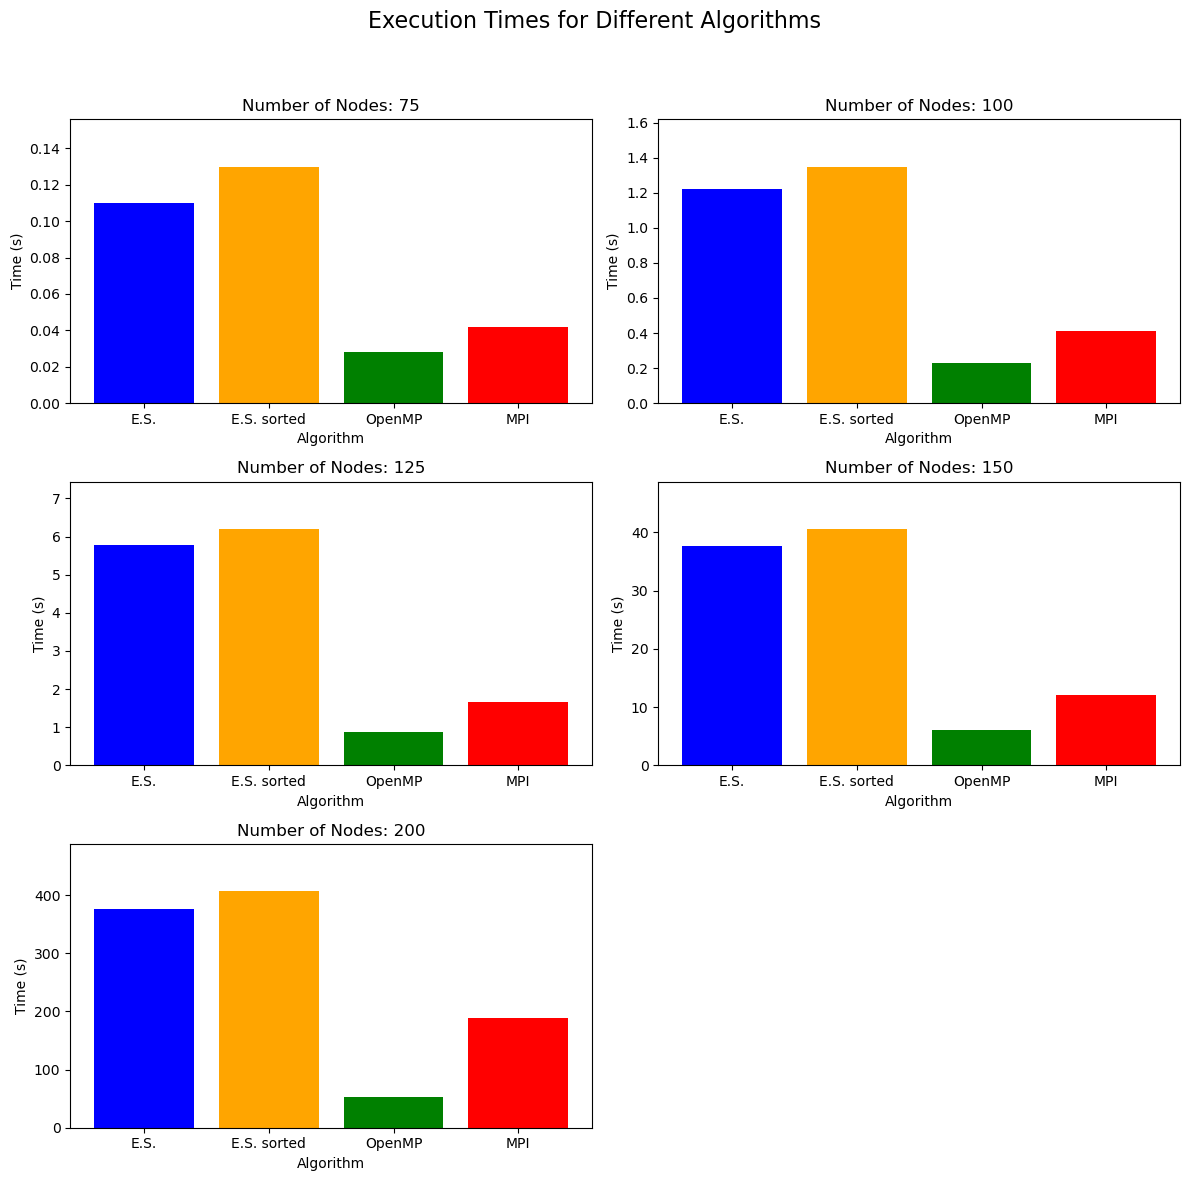
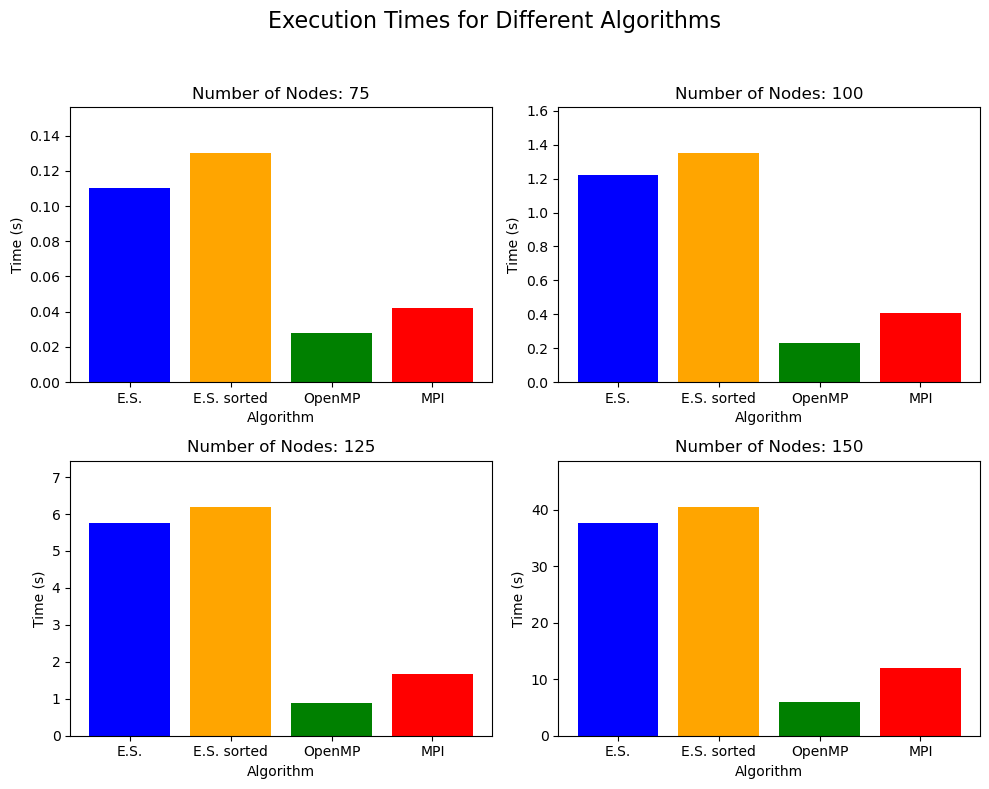

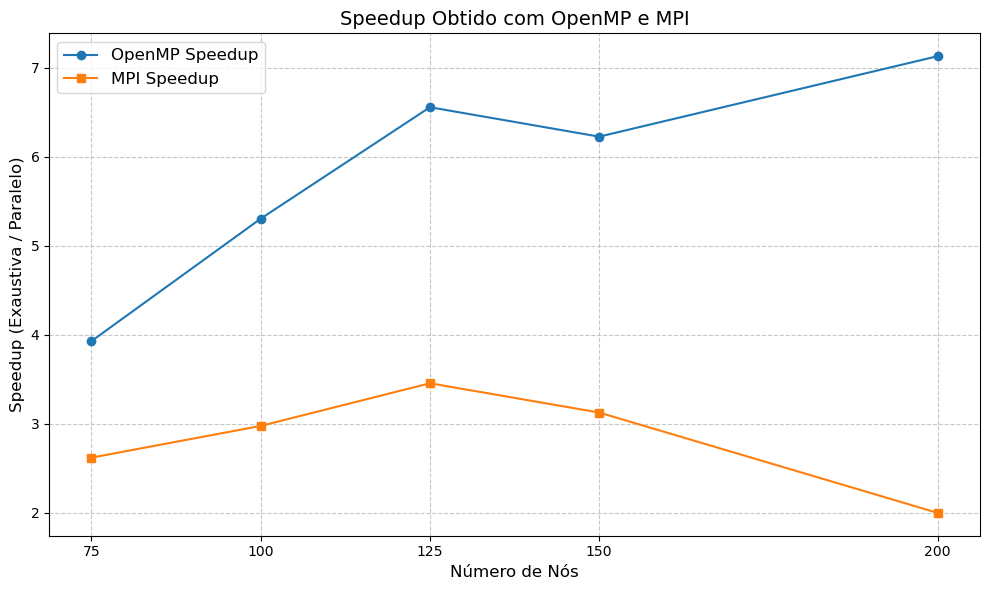
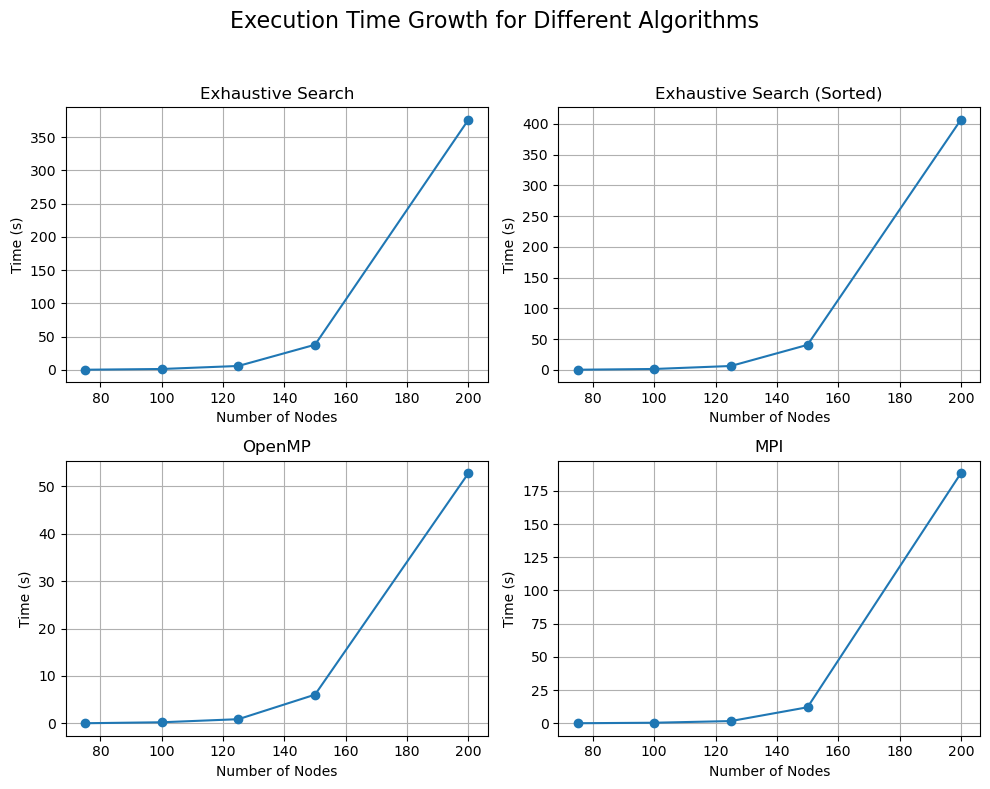

#### Análise dos Resultados

**Desempenho das Abordagens**

- Abordagem Exaustiva Sem Ordenação:

    - Observa-se um aumento exponencial do tempo de execução com o aumento do número de nós.
    - Para 75 nós, o tempo de execução é de 0,11 segundos, enquanto para 200 nós chega a 376,20 segundos (~6 minutos).
    - Este comportamento é esperado devido à natureza combinatória do problema.

- Abordagem Exaustiva com Ordenação por Grau:

    - Curiosamente, os tempos de execução são ligeiramente maiores do que na abordagem sem ordenação.
    - O overhead introduzido pelo processo de ordenação dos nós não resultou em uma redução significativa no espaço de busca.
    - Isso sugere que, para este conjunto de grafos, a ordenação por grau não contribuiu para podas efetivas na árvore de busca.

- Implementação com OpenMP:

    - Apresenta tempos de execução significativamente menores em comparação com as abordagens exaustivas.
    - Para 75 nós, o tempo é de apenas 0,028 segundos, uma redução de aproximadamente 75% em relação à abordagem exaustiva sem ordenação.
    - Para 200 nós, o tempo é de 52,76 segundos, representando uma redução de aproximadamente 86% em relação à abordagem exaustiva.

- Implementação com MPI:

    - Os tempos de execução são melhores do que as abordagens exaustivas, mas não tão eficientes quanto a implementação com OpenMP.
    - Para grafos menores (75 nós), o overhead de comunicação pode estar contribuindo para um desempenho inferior ao OpenMP.
    - À medida que o tamanho do grafo aumenta, a implementação com MPI apresenta melhorias, mas ainda fica atrás do OpenMP.

#### Conclusões dos Resultados

- Paralelização é Essencial:

    - As abordagens paralelas (OpenMP e MPI) são fundamentais para lidar com o aumento exponencial da complexidade do problema.

- OpenMP Mostrou-se Mais Eficiente:

    - Para os tamanhos de grafos testados, o OpenMP superou o MPI em termos de desempenho.
    - O menor overhead de comunicação e a eficiência da memória compartilhada contribuíram para esse resultado.

- Avaliação Cuidadosa de Heurísticas:

    - Heurísticas devem ser avaliadas no contexto específico do problema e da estrutura do grafo.
    - O overhead introduzido por uma heurística pode não compensar se ela não resultar em podas significativas.

#### Extra

Foi implementado um código em CUDA para rodar o algoritmo para encontrar o clique máximo em GPU. O arquivo se encontra em `/src/max_clique.cu`. Ele não foi colocado na análise como os outros e teve o pior desempenho, chegando a 35 segundos de execução para o grafo de 125 nós. Anteriormente, o que levou mais tempo para calcular o clique máximo desse grafo tinha sido o busca exaustiva ordenado que gastou 6.2 segundos.